In [3]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# Import useful files
recipes = pd.read_csv('database/recipe_final_utf8.csv')
correspondancetable = pd.read_csv('database/q.csv', index_col=0) # binary table with 0/1 if ingredient in recipe
correspondancetable.reset_index(drop=True, inplace=True)
recipes_type_cuisine = pd.read_csv('recipes-classification/recipes_by_type_cuisine.csv')
recipes_type_cuisine.set_index('recipe_id', inplace=True)
ingredients = pd.read_csv('database/top131ingredients.csv')

In [5]:
recipes_ing = recipes.merge(correspondancetable, left_index=True, right_index=True)
recipes_ing.set_index('recipe_id', inplace=True)

In [6]:
recipes_ing.head()

,id,title,Ingredients,Directions,numberofsteps,1,2,3,4,5,...,122,123,124,125,126,127,128,129,130,131
recipe_id,,,,,,,,,,,,,,,,,,,,,
1,1584,Foul Moudammas,\r* 1 cup cooked fava beans or canned fava bea...,== Directions ==\r# Drain fava beans. Put in a...,5,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1624,Potato Dumplings,\r* 2 pounds [[potato]]es\r* [[all-purpose flo...,== Directions ==\r# Boil [[potato]]es until te...,11,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1636,Lebanese Basic Dough,\r* 5 cups plain [[flour]]\r* 1å_ cups tepid [...,== Directions ==\r# Sift the [[flour]] into a ...,10,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1655,Yakhnet Bathinjan,"\r* 16 oz black [[eggplant]]s, peeled, cubed\r...",== Directions ==\r# Sprinkle [[salt]] on [[egg...,11,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1660,Manakeesh bi Zaatar,\r* 2å_ cups plain [[flour]]\r* 1 tsp [[yeast]...,== Directions ==\r# Dilute the [[rice]] in a b...,5,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## Deleting the most frequent ingredients

To make the clustering more precise, we try to remove the 20 most frequent ingredients

In [14]:
serie_freq.order(ascending=False)[:15]

1     953
9     540
6     528
58    476
5     474
2     413
12    355
4     350
3     258
7     255
8     203
13    202
24    199
15    182
23    175
dtype: int64

In [17]:
# Getting the count of presence of each ingredient
serie_freq = recipes_ing.iloc[:,5:].sum(axis=0)

# Take list of n most frequent ingredients indices
n = 10
idx_10mostfreq_ing = serie_freq.order(ascending=False)[:n].index.astype(int).tolist()
names_mostfreq_ing = ingredients.ix[idx_20mostfreq_ing]['ingredients'].tolist()
print 'The {0} most frequent ingredients are {1}'.format(n, names_mostfreq_ing)

The 10 most frequent ingredients are ['onion', 'black pepper', 'pepper', 'mint', 'egg', 'garlic', 'oil', 'butter', 'water', 'tomato']


In [20]:
# Removing these "noisy" ingredients from the datasets
str_idx_10mostfreq_ing = [str(item) for item in idx_10mostfreq_ing]
recipes_subset_ing = recipes_ing.drop(str_idx_10mostfreq_ing, axis=1)

In [21]:
recipes_subset_ing

,id,title,Ingredients,Directions,numberofsteps,8,10,11,13,14,...,122,123,124,125,126,127,128,129,130,131
recipe_id,,,,,,,,,,,,,,,,,,,,,
1,1584,Foul Moudammas,\r* 1 cup cooked fava beans or canned fava bea...,== Directions ==\r# Drain fava beans. Put in a...,5,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1624,Potato Dumplings,\r* 2 pounds [[potato]]es\r* [[all-purpose flo...,== Directions ==\r# Boil [[potato]]es until te...,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1636,Lebanese Basic Dough,\r* 5 cups plain [[flour]]\r* 1å_ cups tepid [...,== Directions ==\r# Sift the [[flour]] into a ...,10,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1655,Yakhnet Bathinjan,"\r* 16 oz black [[eggplant]]s, peeled, cubed\r...",== Directions ==\r# Sprinkle [[salt]] on [[egg...,11,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1660,Manakeesh bi Zaatar,\r* 2å_ cups plain [[flour]]\r* 1 tsp [[yeast]...,== Directions ==\r# Dilute the [[rice]] in a b...,5,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
6,1724,Labna,\r* 2 kg Greek [[yogurt]]\r* 75 ml extra virgi...,== Directions ==\r# Mix all ingredients togeth...,6,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1750,Fasolakia,\r\r* 2 lbs fresh [[green bean]]s\r* 1 large c...,== Directions ==\r# Clean and wash the [[green...,4,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,1834,Kremithosoupa,\r* 2 cups [[onion]]s\r* å_ cup [[olive oil]]\...,"== Directions ==\r# Peel, wash and cube the [[...",4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1910,Toshiko's Broccoli Salad,"\r* 1 kg [[broccoli]], cut into florets\r* 2 t...",== Directions ==\r# Bring a large pot of [[wat...,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
recipes_type_cuisine.head()

,title,ingredients_clean_dumbwords,predictions
recipe_id,,,
1,Foul Moudammas,cooked fava beans or canned fava beans lemon j...,italian
2,Potato Dumplings,potatoes allpurpose flour as required nutmeg e...,southern_us
3,Lebanese Basic Dough,plain flour tepid water olive oil vegetable oi...,indian
4,Yakhnet Bathinjan,black eggplants peeled cubed lamb stew meat cu...,southern_us
5,Manakeesh bi Zaatar,plain flour yeast dissolved in of water. a gen...,jamaican


### Computing the Jaccard coefficient for all recipes pairs

**Warning** : this function is VERY slow.

**N.B** :  Could have used `sklearn.metrics` (built-in Jaccard similarity function)

- [See stackoverflow question here](http://stackoverflow.com/questions/37003272/how-to-compute-jaccard-similarity-from-a-pandas-dataframe)

`from sklearn.metrics.pairwise import pairwise_distances 
array = (1 - pairwise_distances(recipes_type_cuisine_dummies, metric = "hamming"))
print array, array.shape
`

### Jaccard coefficient : a measure of similarity

Jaccard coefficient: J= (number of matching presences) / (number of attributes not involved in 00 matches)

J = $(f_{11})\over((f_{01} + f_{10} + f_{11})) $
 
- f01 = 1 the number of attributes where x was 0 and y was 1
- f10 = 2 the number of attributes where x was 1 and y was 0
- f00 = 5 the number of attributes where x was 0 and y was 0
- f11 = 2 the number of attributes where x was 1 and y was 1

### Jaccard distance : measure of dissimilarity

In [ ]:
# Import the Jaccard matrix of the recipes dataset
df_jaccard = pd.read_csv('jaccard_recipes.csv',header=None)
df_jaccard.index += 1
df_jaccard.index.rename('recipe_id',inplace=True)
df_jaccard.columns = range(1,1525)

In [ ]:
df_jaccard.head()

In [ ]:
# Create new dataframe with Jaccard coefs + info about each recipe
recipes_jaccoef_info = recipes_ing.iloc[:,:5].merge(df_jaccard, how='inner', left_index=True, right_index=True)

In [ ]:
recipes_jaccoef_info.head()

In [ ]:
# Saving this dataframe
recipes_jaccoef_info.to_csv('recipes_info_and_jaccoef.csv', header=True)

## Using `sklearn.metrics.jaccard_similarity_score`

In [11]:
from sklearn.metrics import jaccard_similarity_score

In [ ]:
 '''
 Creating a similarity dataframe
   - Dataframe where 1 row = 1 recipe,
   - 1 column = another recipe",
   - Square df of length n = # of recipes",
   - element mij = Jaccard coefficient for recipe i and j
 '''
from sklearn.metrics import jaccard_similarity_score

list_jscore = []
for idx, row in ing_vectors.iterrows(): #dataframe index; row: each row in series format
    j_scores_row = []
    for idx, otherrow in ing_vectors.iterrows():
        j_score = jaccard_similarity_score(row.tolist(), otherrow.tolist())
        j_scores_row.append(j_score)
    list_jscore.append(j_scores_row)

### Testing on some examples

In [ ]:
recipe3 = recipes_jaccoef_info.iloc[2,:]
list_scores_rec3 = recipe3.iloc[5:].tolist()

In [ ]:
recipes_jaccoef_info.loc[3]

In [ ]:
from operator import itemgetter
indices, list_scores_rec3_sorted = zip(*sorted(enumerate(list_scores_rec3), key=itemgetter(1), reverse=True))

In [ ]:
list_recipes = recipes_jaccoef_info['title'].tolist()
top50indices = indices[:50]
top50_similar_recipe3 = [list_recipes[i] for i in top50indices]

In [ ]:
print top50_similar_recipe3

In [ ]:
def get_top_n_similar(n, recipe_id):
    '''
    Given the recipe_id number and the desired number of most similar recipes, returns a list of most similar
    recipes in descending order.
    NB : the 1st most similar one should be the recipe itself. 
    '''
    this_recipe = recipes_jaccoef_info.loc[recipe_id]
    list_jaccoefs = this_recipe.iloc[5:].tolist()
    
    # Sorting the Jaccard coefficients of all other recipes with this one by descending order
    from operator import itemgetter
    indices, list_jaccoefs_sorted = zip(*sorted(enumerate(list_jaccoefs), key=itemgetter(1), reverse=True))
    
    # Taking the first n recipes
    list_recipes = recipes_jaccoef_info['title'].tolist()
    top_n = indices[:n]
    top_n_similar_this_recipe = [list_recipes[i] for i in top_n]
    
    return top_n_similar_this_recipe   

In [ ]:
def get_top_n_dissimilar(n, recipe_id):
    '''
    Given the recipe_id number and the desired number of most similar recipes, returns a list of least similar
    recipes in ascending order. (the worst the first)
    '''
    this_recipe = recipes_jaccoef_info.loc[recipe_id]
    list_jaccoefs = this_recipe.iloc[5:].tolist()
    
    # Sorting the Jaccard coefficients of all other recipes with this one by ascending order
    from operator import itemgetter
    indices, list_jaccoefs_sorted = zip(*sorted(enumerate(list_jaccoefs), key=itemgetter(1)))
    
    # Taking the first n recipes
    list_recipes = recipes_jaccoef_info['title'].tolist()
    top_n = indices[:n]
    top_n_dissimilar_this_recipe = [list_recipes[i] for i in top_n]
    
    return top_n_dissimilar_this_recipe 

In [ ]:
# Chicken plate
get_top_n_similar(20, 1523)

In [ ]:
get_top_n_dissimilar(20, 1523)

In [ ]:
recipes_jaccoef_info.iloc[600:620]

In [ ]:
get_top_n_similar(15, 601)

In [ ]:
get_top_n_similar(20, 404)

## Clustering recipes to combine similarity based on list of ingredients and classification by type of cuisine

- "If you have binary values, discrete attributes or categorial attributes, stay away from k-means. K-means needs to compute means, and the mean value is not meaningful on this kind of data."
- Why K-Means is weak with categorical data, use Hamming distance or modes see [here]('https://www.quora.com/Why-in-categorical-data-k-means-clustering-is-weak')

### Computing similarity scores manually on category of cuisine

#### Set of rules:

In [6]:
recipes_type_cuisine.head()

,title,ingredients_clean_dumbwords,predictions
recipe_id,,,
1,Foul Moudammas,cooked fava beans or canned fava beans lemon j...,italian
2,Potato Dumplings,potatoes allpurpose flour as required nutmeg e...,southern_us
3,Lebanese Basic Dough,plain flour tepid water olive oil vegetable oi...,indian
4,Yakhnet Bathinjan,black eggplants peeled cubed lamb stew meat cu...,southern_us
5,Manakeesh bi Zaatar,plain flour yeast dissolved in of water. a gen...,jamaican


In [7]:
recipes_type_cuisine.groupby('predictions').count()

,title,ingredients_clean_dumbwords
predictions,,
brazilian,6,6
british,60,60
cajun_creole,34,34
chinese,38,38
filipino,58,58
french,106,106
greek,54,54
indian,86,86
irish,12,12


In [8]:
def categorize_cuisine(value):
    if value in ['brazilian', 'cajun_creole', 'jamaican']:
        new_value = 'exotic'
    else:
        if value in ['korean', 'thai', 'vietnamese', 'chinese', 'filipino']:
            new_value = 'asian'
        else:
            if value in ['irish', 'british']:
                new_value = 'british'
            else:
                if value in ['moroccan', 'spanish', 'greek']:
                    new_value = 'mediterranean'
                else:
                    new_value = value
    return new_value        

In [9]:
recipes_type_cuisine['type_cuisine'] = recipes_type_cuisine['predictions'].apply(categorize_cuisine)

In [10]:
recipes_type_cuisine.groupby('type_cuisine').count()

,title,ingredients_clean_dumbwords,predictions
type_cuisine,,,
asian,120,120,120
british,72,72,72
exotic,77,77,77
french,106,106,106
indian,86,86,86
italian,237,237,237
japanese,94,94,94
mediterranean,74,74,74
mexican,148,148,148


In [14]:
recipes_type_cuisine_dummies = pd.get_dummies(recipes_type_cuisine['type_cuisine'])
recipes_type_cuisine_dummies.head()

,asian,british,exotic,french,indian,italian,japanese,mediterranean,mexican,russian,southern_us
recipe_id,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def compare_rows(df,row1,row2):
    """Returns the column numbers in which both rows contain 1's"""
    column_numbers = []
    for i,_ in enumerate(df): # Loop over all columns
        if (df.ix[row1,i] == 1) and (df.ix[row2,i] ==1):
            column_numbers.append(i)
    return column_numbers

In [59]:
def compare_rows_fast(df,row1,row2):
    """Returns the column numbers in which both rows contain 1's"""
    import itertools
    res = np.where((df.iloc[row1] * df.iloc[row2]))
    return list(itertools.chain.from_iterable(res))[1:]
    

In [60]:
compare_rows(subset100, 0,1)

[6]

In [61]:
compare_rows_fast(subset100, 0,1)

[6]

In [63]:
def compute_recipe_similarity(df):
    n = len(df.index)
    array_sim_cuisine = np.empty([n, n])
    for i, row in df.iterrows():
        for j, otherrow in df.iterrows():
            comp = compare_rows(df, i, j)
            if comp:
                array_sim_cuisine[i,j] = 1
            else:
                array_sim_cuisine[i,j] = 0
                
            
    return array_sim_cuisine 

In [64]:
def compute_recipe_similarity_fast(df):
    n = len(df.index)
    array_sim_cuisine = np.empty([n, n])
    for i, row in df.iterrows():
        for j, otherrow in df.iterrows():
            comp = compare_rows_fast(df, i, j)
            if comp:
                array_sim_cuisine[i,j] = 1
            else:
                array_sim_cuisine[i,j] = 0
                
            
    return array_sim_cuisine 

Unit testing:

In [18]:
subset_asian = recipes_type_cuisine_dummies[recipes_type_cuisine_dummies['asian']==1].sample(n=5).reset_index()
subset_mediter = recipes_type_cuisine_dummies[recipes_type_cuisine_dummies['mediterranean']==1].sample(n=5).reset_index()
subset = recipes_type_cuisine_dummies.sample(n=5).reset_index()

In [ ]:
print range(1, len(subset_asian.columns))
print subset_asian

In [ ]:
subset_asian.ix[0,11]

In [29]:
compute_recipe_similarity2(subset_asian)

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [30]:
compute_recipe_similarity2(subset_mediter)

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [32]:
subset

,recipe_id,asian,british,exotic,french,indian,italian,japanese,mediterranean,mexican,russian,southern_us
0,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,251,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [31]:
compute_recipe_similarity2(subset)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [35]:
subset100 = recipes_type_cuisine_dummies.sample(n=100).reset_index()
subset100

,recipe_id,asian,british,exotic,french,indian,italian,japanese,mediterranean,mexican,russian,southern_us
0,749,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,327,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1477,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,761,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,852,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,284,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,848,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
compute_recipe_similarity2(subset100)

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  1.]])

In [65]:
# Time computation
%timeit compute_recipe_similarity_fast(subset100)

1 loop, best of 3: 5.95 s per loop


In [66]:
# Time computation
%timeit compute_recipe_similarity(subset100)

1 loop, best of 3: 48.8 s per loop


In [68]:
recipes_type_cuisine_dummies.head()

,asian,british,exotic,french,indian,italian,japanese,mediterranean,mexican,russian,southern_us
recipe_id,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
recipes_type_cuisine_dummies.loc[1]

asian            0.0
british          0.0
exotic           0.0
french           0.0
indian           0.0
italian          1.0
japanese         0.0
mediterranean    0.0
mexican          0.0
russian          0.0
southern_us      0.0
Name: 1, dtype: float64

In [71]:
# Computing on the whole dataset
sim_type_cuisine = compute_recipe_similarity_fast(recipes_type_cuisine_dummies.reset_index())

In [72]:
np.savetxt("sim_type_cuisine.csv", sim_type_cuisine, delimiter=",")

In [74]:
print sim_type_cuisine
print sim_type_cuisine.shape

[[ 1.  0.  0. ...,  0.  1.  1.]
 [ 0.  1.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  1.  0.  0.]
 [ 1.  0.  0. ...,  0.  1.  1.]
 [ 1.  0.  0. ...,  0.  1.  1.]]
(1524, 1524)


#### Jaccard similarity coefficient
[See stackoverflow question here](http://stackoverflow.com/questions/37003272/how-to-compute-jaccard-similarity-from-a-pandas-dataframe)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances 
array = (1 - pairwise_distances(recipes_type_cuisine_dummies, metric = "hamming"))
print array, array.shape

In [ ]:
recipes_type_cuisine_dummies.columns.to_list()

## Merging type of cuisine sim + ingredients sim

See (`sklearn.cluster.SpectralClustering`)[http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering]
- Clustering based on my own custom similarity matrix which is a weighted sum of ingredients similarity + type of cuisine similarity 
- (Chosing the right k for Spectral Clustering)[https://www.quora.com/Can-spectral-clustering-automatically-determine-the-number-of-clusters]

In [75]:
from numpy import genfromtxt
array_sim_ing = genfromtxt('jaccard_recipes.csv', delimiter=',')
array_sim_type_cuisine = genfromtxt('sim_type_cuisine.csv', delimiter=',')

In [76]:
array_sim_ing.shape == array_sim_type_cuisine.shape

True

#### Weighted sum : need to choose accurate weights

In [129]:
w1 = 3/5.
w2 = 2/5.
sim_matrix = np.add(float(w1)*array_sim_ing, float(w2)*array_sim_type_cuisine)
print sim_matrix[0], sim_matrix.shape

[ 1.          0.          0.06       ...,  0.          0.46        0.44285714] (1524, 1524)


In [130]:
# sparsity
np.count_nonzero(sim_matrix)/float(1524**2)

0.7237136696495615

In [131]:
from sklearn.cluster import SpectralClustering


## t-SNE dim reduction for visualization

t-SNE (TSNE) **converts affinities of data points to probabilities**. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. 
 
-  "If metric is “precomputed”, X is assumed to be a distance matrix"
- distance matrix => inverse of similarity matrix
 

In [132]:
1 - sim_matrix

array([[ 0.        ,  1.        ,  0.94      , ...,  1.        ,
         0.54      ,  0.55714286],
       [ 1.        ,  0.        ,  0.94      , ...,  0.55      ,
         1.        ,  0.95714286],
       [ 0.94      ,  0.94      ,  0.        , ...,  0.95384615,
         0.94545455,  0.91428571],
       ..., 
       [ 1.        ,  0.55      ,  0.95384615, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.54      ,  1.        ,  0.94545455, ...,  1.        ,
         0.        ,  0.6       ],
       [ 0.55714286,  0.95714286,  0.91428571, ...,  1.        ,
         0.6       ,  0.        ]])

In [133]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, metric='precomputed', random_state=0)
X = 1 - sim_matrix
dimred_X = model.fit_transform(X) 

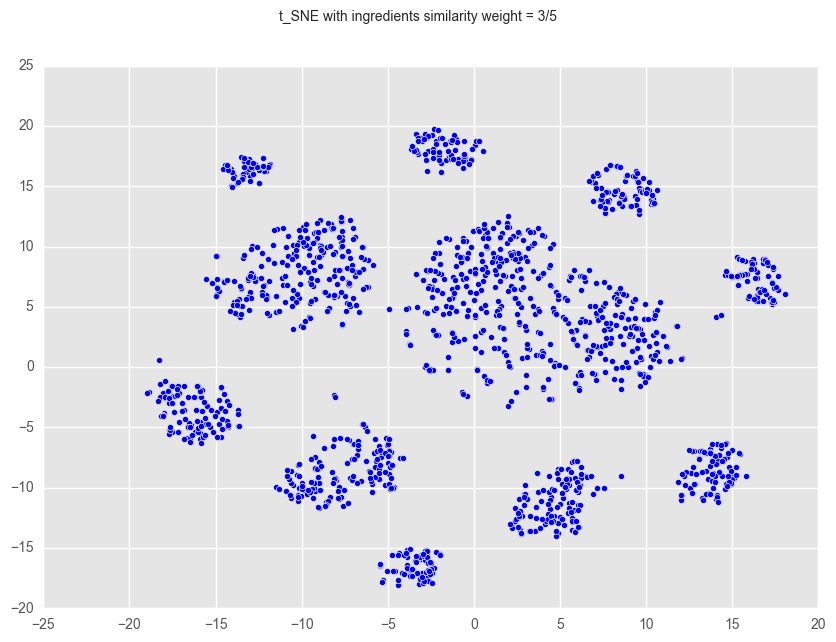

In [134]:
fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.scatter(dimred_X[:,0], dimred_X[:,1])
fig1.suptitle('t_SNE with ingredients similarity weight = 3/5')
fig1.savefig('tSNE_3-5_2-5.png')

In [120]:
X[:,0].shape

(1524,)

## Spectral Embedding

Forms an **affinity matrix** given by the specified function and applies **spectral decomposition** to the corresponding graph laplacian. The resulting transformation is given by the value of the eigenvectors for each data point.

In [135]:
# Spectral Embedding
from sklearn.manifold import SpectralEmbedding
model2 = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=0)
spectral_X = model2.fit_transform(sim_matrix) 

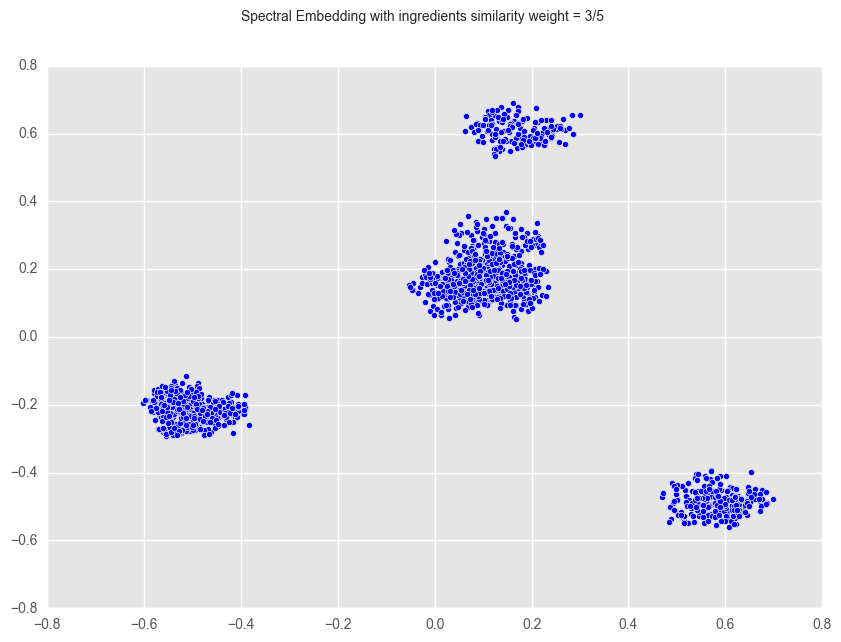

In [136]:
fig2, ax2 = plt.subplots(figsize=(10, 7))
ax2.scatter(spectral_X[:,0], spectral_X[:,1])
fig2.suptitle('Spectral Embedding with ingredients similarity weight = 3/5')
fig2.savefig('spectral_embedding_3-5_2-5.png')

## Spectral Clustering

In [169]:
clustering_model = SpectralClustering(n_clusters=11, eigen_solver=None, random_state=None, affinity='precomputed')
labels = clustering_model.fit_predict(sim_matrix)

In [156]:
labels

array([4, 1, 6, ..., 1, 4, 4], dtype=int32)

In [157]:
list(np.unique(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

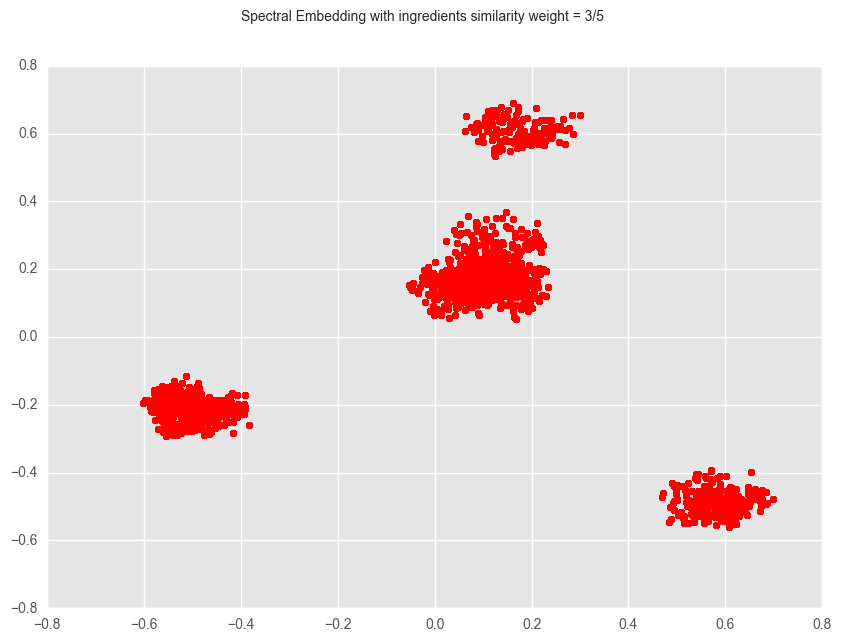

In [149]:
import matplotlib.cm as cm
fig3, ax3 = plt.subplots(figsize=(10, 7))
n_clusters = list(labels)



colors = iter(cm.rainbow(np.linspace(0, 1, len(n_clusters))))
for n in n_clusters:
    ax3.scatter(spectral_X[:,0], spectral_X[:,1], color=next(colors))


fig3.suptitle('Spectral Clustering with ingredients similarity weight = 3/5')
#fig3.savefig('spectral_embedding_3-5_2-5.png')

In [ ]:
ABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   ....,
                   }

label_color = [LABEL_COLOR_MAP[l] for l in labels]
plt.scatter(x, y, c=label_color)

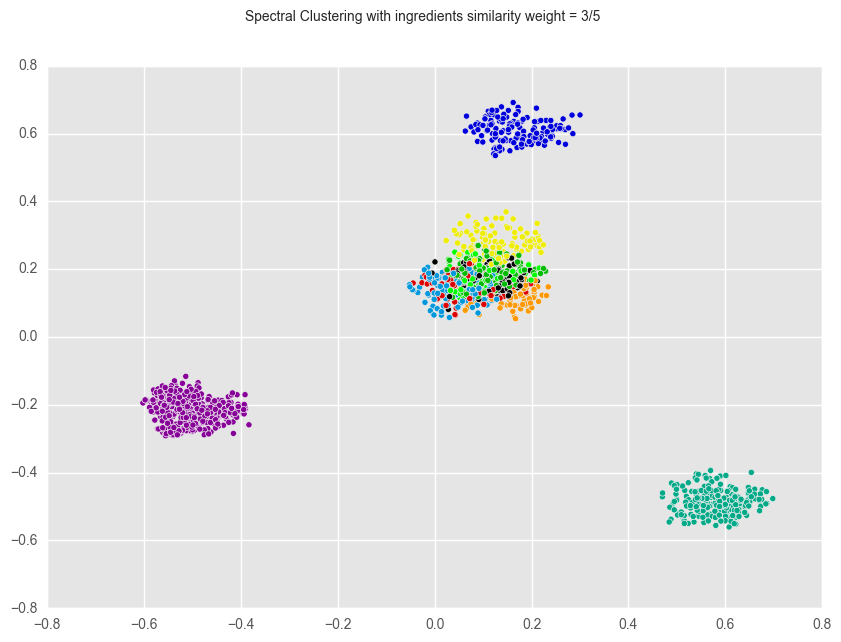

In [158]:
import matplotlib.cm as cm
fig3, ax3 = plt.subplots(figsize=(10, 7))
n_clusters = list(labels)



ax3.scatter(spectral_X[:,0], spectral_X[:,1], c=[cm.spectral(float(i) /10) for i in n_clusters]); 


fig3.suptitle('Spectral Clustering with ingredients similarity weight = 3/5')
#fig3.savefig('spectral_embedding_3-5_2-5.png')


In [159]:
count_clusters = pd.Series(labels).value_counts()
print count_clusters

1    454
4    237
2    148
3    128
7    120
5    106
0     94
6     86
9     77
8     74
dtype: int64


In [168]:
recipes_type_cuisine.groupby('type_cuisine').count()

,title,ingredients_clean_dumbwords,predictions
type_cuisine,,,
asian,120,120,120
british,72,72,72
exotic,77,77,77
french,106,106,106
indian,86,86,86
italian,237,237,237
japanese,94,94,94
mediterranean,74,74,74
mexican,148,148,148


In [160]:
labels

array([4, 1, 6, ..., 1, 4, 4], dtype=int32)

## Choosing k : silhouette score 

- [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
- precomputed metric

**Conclusion**
- best k = 11 actually corresponds to number of cuisine categories...
- idea: Cluster by food category. Choose N0 recipes from all food categories. Give score i to food cluster i. Ponderate this score for each recipe by similarity with n from N0 ?

Automatically created module for IPython interactive environment
For n_clusters = 5 The average silhouette_score is : 0.659472723726


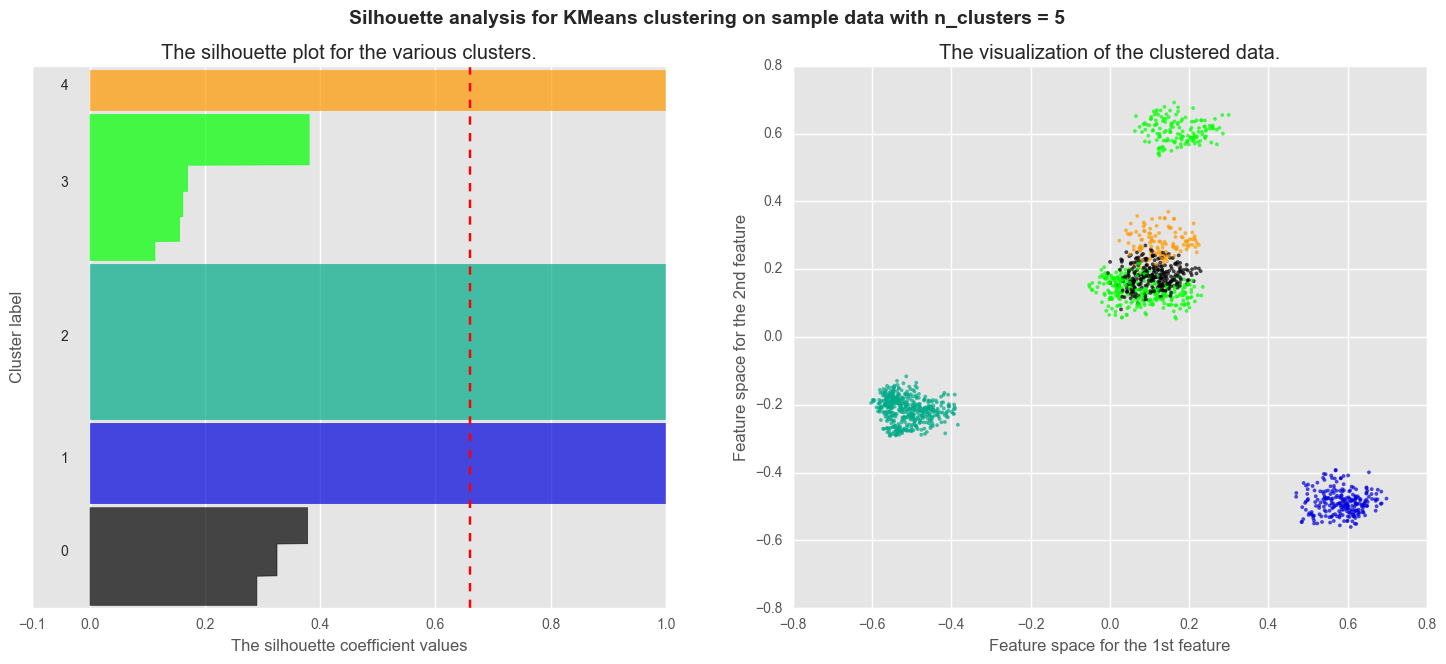

For n_clusters = 7 The average silhouette_score is : 0.568648771267


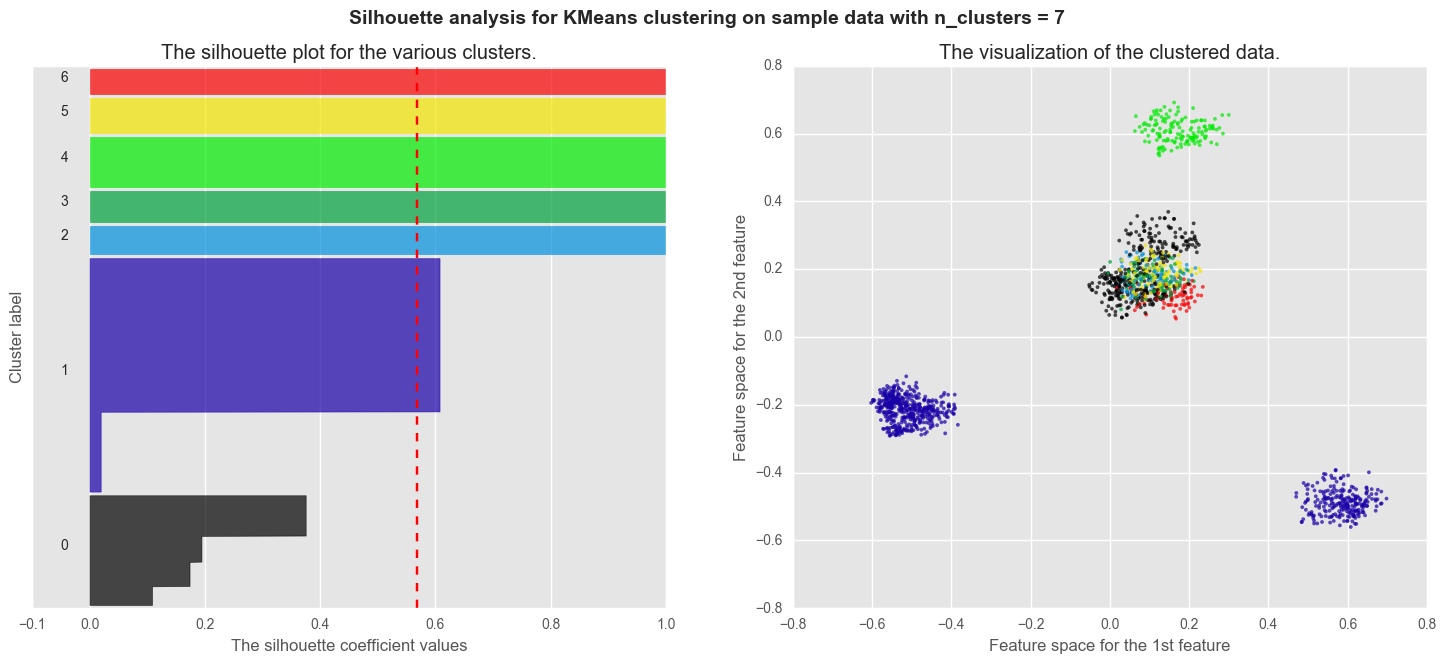

For n_clusters = 9 The average silhouette_score is : 0.840386663808


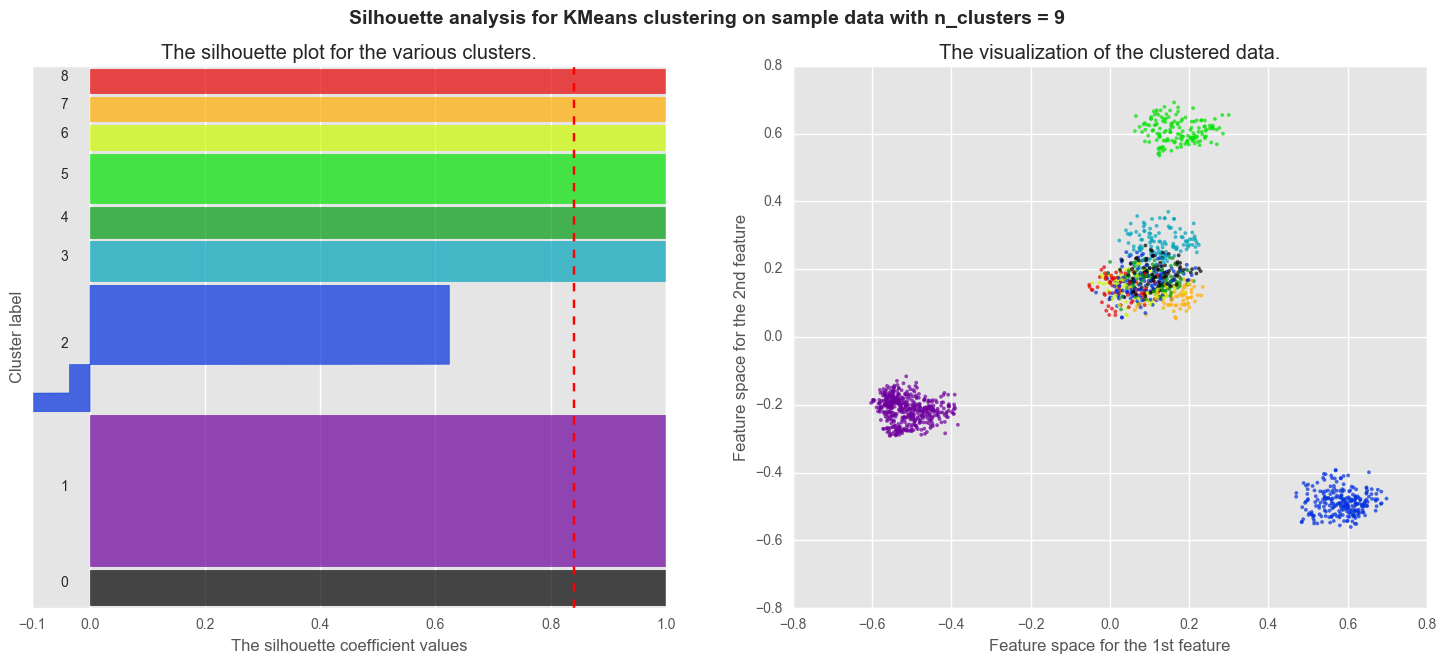

For n_clusters = 11 The average silhouette_score is : 1.0


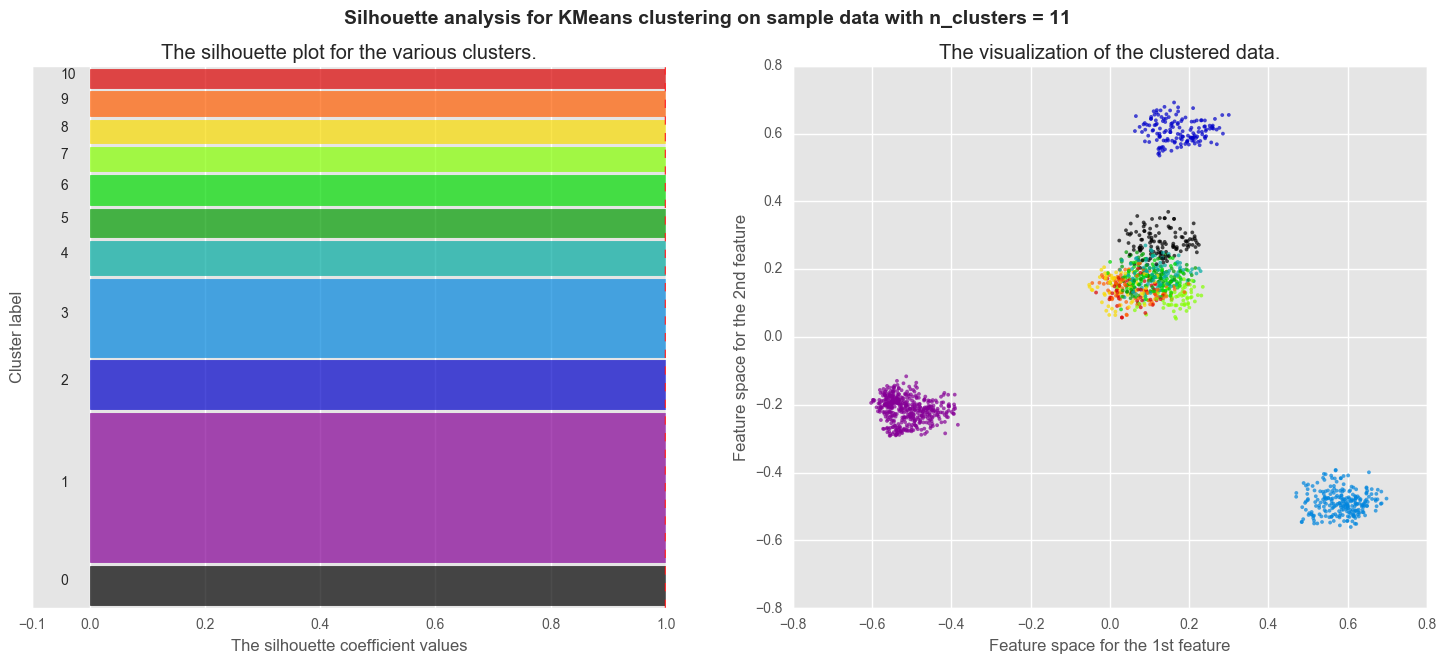

For n_clusters = 13 The average silhouette_score is : nan


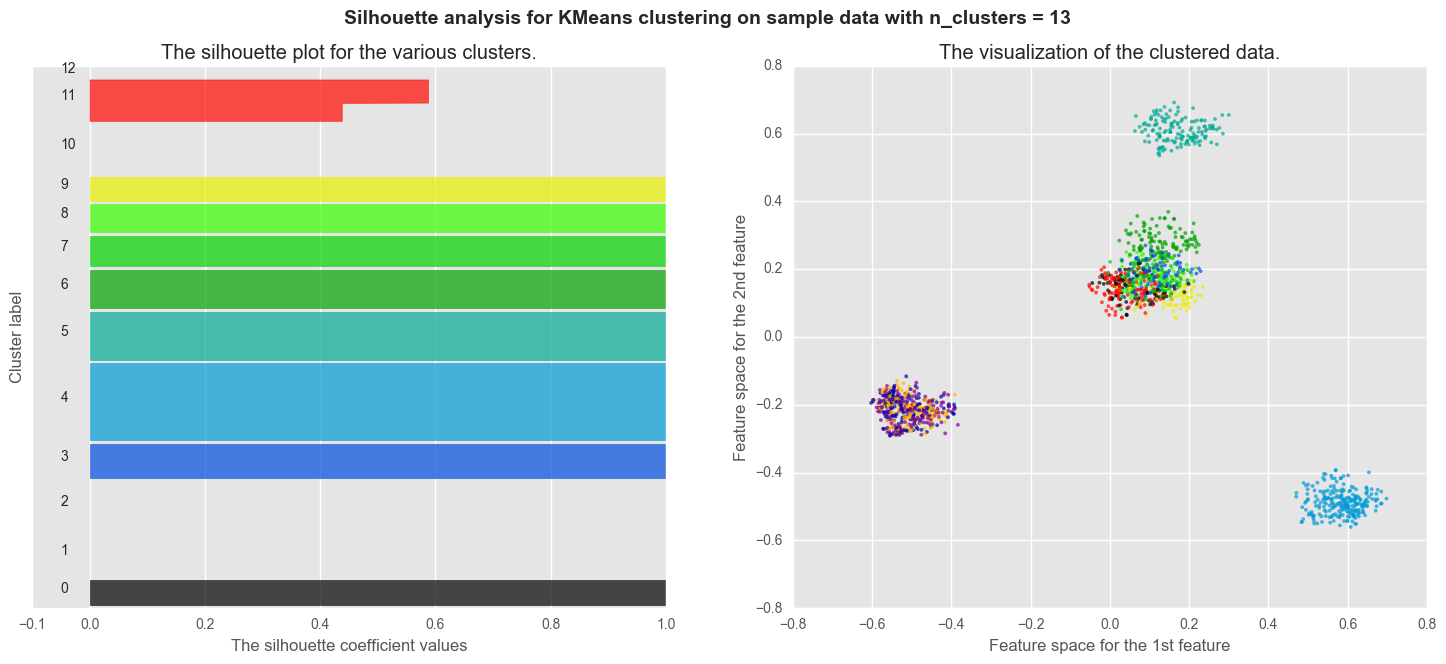

In [184]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Choose weights for ingredients similarity (w1) and for type of cuisine (w2)
w1 = 0.
w2 = 1.
sim_matrix = np.add(float(w1)*array_sim_ing, float(w2)*array_sim_type_cuisine)

X = sim_matrix

range_n_clusters = [5, 7, 9, 11, 13]

fileNameTemplate = 'plots-clustering\Plot_ing0_typecuis1{0:02d}.png'

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = SpectralClustering(n_clusters=n_clusters, eigen_solver=None, random_state=None, affinity='precomputed')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(spectral_X[:,0], spectral_X[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers -> NO NOTION OF CLUSTER CENTERS IN SPECTRAL CLUSTERING !
    #ax2.scatter(centers[:, 0], centers[:, 1],
     #           marker='o', c="white", alpha=1, s=200)

    #for i, c in enumerate(centers):
     #   ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    plt.savefig(fileNameTemplate.format(n_clusters, format='png'))
    plt.clf()

In [172]:
fig.savefig('silhouette_score_spectralclust.png') # only saves the last cluster